# How to use this!

1. Check out if all the parameters are right by doing a single run. This also allows you to explore the paramerers, read their info!!
1. Then generate the workplans (variations in start times, altitudes, etc.)

# Imports

In [1]:
import hysplit_py
import os
from hysplit_py import land_use_map as lume
import pathlib
import numpy as np
import matplotlib.pylab as plt
import atmPy # this is only because of the basemap import problem
from mpl_toolkits.basemap import Basemap
import xarray as xr
import copy


/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:27: UserWarning: mpl_toolkits.basemap not available or not functioning properly, some features of hysplit_py will not work
  warnings.warn(txt)
/mnt/telg/prog/hysplit-py/hysplit_py/land_use_map.py:10: UserWarning: gdal not found, this will probably result in prublems (with respect to landuse) further down the road
  warnings.warn('gdal not found, this will probably result in prublems (with respect to landuse) further down the road')


In [2]:
import os

In [3]:
os.getpid()

27225

In [4]:
plt.rcParams['figure.dpi'] = 150

# Helpers

In [5]:
def row2fname_out(row):
    sdt = row.start_datetime
    namecomps = []
    
    namecomps.append(f'{sdt.year}{sdt.month:02d}{sdt.day:02d}_{sdt.hour:02d}{sdt.minute:02d}{sdt.second:02d}')    
    namecomps.append(f'{row.altitude}m')
    namecomps.append(row.hy_mode)

    fname = '_'.join(namecomps)
    fname += '.nc'
    return fname

def finish_run_info(run_info):
    #meterologic_data_format
    run_info['met_format'] = meterologic_data_format
    
    # run_time
    run_info['run_time'] = run_time

    # coordinates 
    run_info['lat'] = coordinates_lat_lon[0]
    run_info['lon'] = coordinates_lat_lon[1]
    # non default setting
    for nds in non_default_settings:
        run_info[nds] = non_default_settings[nds]

    # hysplit mode
    hm_list = []
    for hm in hysplit_mode:
        run_info['hy_mode'] = hm
        hm_list.append(run_info.copy())
    run_info = pd.concat(hm_list)

    # make output names
    run_info['file_name'] = run_info.apply(row2fname_out, axis=1)
    assert(run_info.file_name.duplicated().sum() == 0), 'file names are not unique, change the format that creates the filenams'

    #sort
    run_info.sort_values('start_datetime', inplace=True)
    return run_info



# settings

## commen run parameters

In [306]:
process_number = 1 # between 1 and 6; 0 is for testing 
run_time = 3 * 7 * 24 # negative for backtrajectory, positive for forward trajectory
# save_base_folder = '/mnt/telg/tmp/hysplit_test/'
save_base_folder = pl.Path('/mnt/data/data/hysplit_products/for_john_augustine_2022/bc_june30th_fire/')

# coordinates_lat_lon = (40.12498, -105.23680) # Table mountain, CO
# coordinates_lat_lon = (13.33, -61.183) # La_Soufriere
# coordinates_lat_lon = (19.5362, -155.5763) # MLO
# coordinates_lat_lon = (24.285, 141.481) # Fukutoku-Okanoba
coordinates_lat_lon = (51.695, -120.8856) # cb_fire

# altitude = [15.8e3, 16.0e3, 16.2e3, 16.4e3, 16.6e3, 16.8e3, 17.0e3, ] # reception or emmission altitudes in meters, for back and forward trajectory, respectively
altitude = list(np.linspace(13e3, 17e3, 9)) # reception or emmission altitudes in meters, for back and forward trajectory, respectively

hysplit_mode = ['traj', 
#                 'conc'
                     ]
meterologic_data_format = 'gdas1' # gfs0p25, gdas0p5, gdas1
                                    # more info with print(run_c.parameters.meterologic_data_format.info()), 
                                    # note this info might be outdated ... see also https://www.ready.noaa.gov/archives.php
        
###############################################
## Non standard settings (create scenarios!?!)
### for stratospheric stuff
###########################

top_of_model_domain = 30000. #usually 10000

## typically no changes needed

In [307]:
path2metfiles = '/mnt/data/data/hysplit_met_files/'
path2hysplit='/mnt/telg/programs/hysplit{:02d}/'.format(process_number)

folders = dict(save_base_folder = save_base_folder,
               path2metfiles = path2metfiles,
               path2hysplit = path2hysplit)

non_default_settings = {}
#### coarse mode particles
# non_default_settings['deposition_particle_diameter'] = 3.5
# non_default_settings['deposition_particle_density'] = 2.6
# non_default_settings['deposition_particle_shape'] = 1.3

#### checks
for fold in folders:
    pass

    pf = pathlib.Path(folders[fold])

    assert(pf.is_dir()), f'{pf}, does not exist'

In [308]:
# save_base_folder.mkdir()

## get parameter info

In [309]:
run = hysplit_py.Run('trajectory', path2hysplit = path2hysplit)

In [310]:
print(run.parameters.meterologic_data_format.info())

Meteorology / ARL Data FTP / Archive


The ARL web server contains several meteorological model data sets already converted into a HYSPLIT compatible format on the public directories. Direct access via FTP to these data files is "hardwired" into the GUI. Only an email address is required for the password to access the server. The "FTP menu" is locked until the FTP process is completed, at which point a message box will appear indicating the file name that was just transferred.

The ARL analysis data archive consists of output from the Global Data Analysis System (GDAS) and the NAM Data Analysis System (NDAS - previously called EDAS) covering much of North America. Both data archives are available from 1997 in semi-monthly files (SM). The EDAS was saved at 80-km resolution every 3-h through 2003, and then at 40-km resolution (AWIPS 212 grid) starting in 2004. The GDAS (every 6-h) was saved on a hemispheric projection at 191-km resolution through the end of 2006. The new 1-degree and hal

# Generate a timeseries of starting times

## at regular intervals

In [311]:
# Need to be adapted to match the "by hand" structure

start = '2021-06-30 22:00:00'
end =   '2021-07-01 00:00:00'
frequency = '0.5H'

############################
run_info = pd.DataFrame(pd.date_range(start, end, freq=frequency), columns = ['start_datetime'] )#, columns=[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
# altitude
if isinstance(altitude, list):
    alt_list = []
    for alti in altitude:
        run_info['altitude'] = alti
        alt_list.append(run_info.copy())
    run_info = pd.concat(alt_list)
else:
    run_info['altitude'] = altitude

run_info = finish_run_info(run_info)

In [312]:
run_info.shape

(45, 8)

In [135]:
run_info

start_datetime  altitude met_format  run_time     lat       lon  \
0 2021-06-30 22:00:00   14000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   17000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   14500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   17000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   17000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   17000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   17000.0      gdas1       504  51.695 -120.8856   

  hy_mode                         file_name  
0    traj  20210630_220000_14000.0m_traj.nc  
0    traj  20210630_220000_16000.0m_traj.nc  
0    traj  20210630_220000_17000.0m_traj.nc  
0    traj  20210630_220000_14500.0m_traj.nc  
0    traj  20210630_220000_15000.0m_traj.nc  
0    traj  20210630_220000_16500.0m_traj.nc  
0    traj  20210630_220000_15500.0m_traj.nc  
1    traj  20210630_223000_16000.0m_traj.nc  
1    traj  20210630_223000_15000.0m_traj.nc  
1    traj  20210630_223000_16500.0m_traj.nc  
1    traj  20210630_223000_14500.0m_traj.nc  
1    traj  20210630_223000_17000.0m_traj.nc  
1    traj  20210630_223000_14000.0m_traj.nc  
1    traj  20210630_223000_15500.0m_traj.nc  
2    traj  20210630_230000_16000.0m_traj.nc  
2    traj  20210630_230000_17000.0m_traj.nc  
2    traj  20210630_230000_16500.0m_traj.nc  
2    traj  20210630_230000_15500.0m_traj.nc  
2    traj  20210630_230000_14000.0m_traj.nc  
2    traj  20210630_230000_15000.0m_traj.nc  
2    traj  20210630_230000_14500.0m_traj.nc  
3    traj  20210630_233000_15500.0m_traj.nc  
3    traj  20210630_233000_14000.0m_traj.nc  
3    traj  20210630_233000_16500.0m_traj.nc  
3    traj  20210630_233000_17000.0m_traj.nc  
3    traj  20210630_233000_14500.0m_traj.nc  
3    traj  20210630_233000_16000.0m_traj.nc  
3    traj  20210630_233000_15000.0m_traj.nc  
4    tra

## by hand

In [ ]:
startdt = [['20090326 092400', 19.8],
          ]
run_info = pd.DataFrame(startdt, columns=['start_datetime', 'altitude'])
run_info.start_datetime = run_info.start_datetime.apply(pd.to_datetime)
run_info.altitude *= 1000
run_info = finish_run_info(run_info)

In [ ]:
run_info

## on particular dates and times

In [ ]:
Need to be adapted to match the "by hand" structure

path2log = pathlib.Path('/mnt/telg/projects/19_hysplit4joe/ceilo_strict_clrsky_periods_start_end_arrays_03.nc')

ds = xr.open_dataset(path2log)

ds

startdt = ds.clr_start.to_dataframe()
startdt = startdt.iloc[:,0]
startdt = plt.num2date(startdt)
list_of_start_datetimes = startdt

# startdt = startdt + [dt + datetime.timedelta(days = 1) for dt in list_of_start_datetimes] + [dt - datetime.timedelta(days = 1) for dt in list_of_start_datetimes]

startdt.sort()

startdt = [pd.to_datetime(sd) for sd in startdt]


startdt = [pd.to_datetime(np.datetime64(sd)) for sd in startdt]

df = pd.DataFrame(startdt, columns = ['start_times'])
df['idx'] = df.index.copy()
shifted = [df]
for i in [1,-1]:
    dft = df.copy()
    dft.loc[:,'start_times'] += pd.Timedelta(i, 'd')
    shifted.append(dft)

df = pd.concat(shifted).sort_values('idx')

startdt = list(df.start_times)
list_of_start_datetimes = startdt

# Run

## single

### trajectory

In [48]:
reload(hysplit_py.split_lab)

<module 'hysplit_py.split_lab' from '/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py'>

In [49]:
start_time = start
# start_time = '2021-05-28 21:01:00' 
# start
# meterologic_data_format = 'gfs0p25'
# meterologic_data_format = 'gdas1'
start_time

'2021-06-30 22:00:00'

In [50]:
# test = False
run_t = hysplit_py.Run('trajectory', path2hysplit = path2hysplit)
run_t.parameters.input_met_data_folder = path2metfiles
run_t.parameters.meterologic_data_format = meterologic_data_format
run_t.parameters.starting_loc = [[coordinates_lat_lon[0], coordinates_lat_lon[1], altitude[0]]]
run_t.parameters.run_time = run_time
run_t.parameters.start_time = start_time
run_t.parameters.output_path
run_t.parameters.top_of_model_domain = top_of_model_domain
run_t.parameters

concentration_grids     :  no grids defined

input_met_data_folder   :  /mnt/data/data/hysplit_met_files/
input_met_file_names    :  ['gdas1.jun21.w5', 'gdas1.jul21.w1', 'gdas1.jul21.w2']
meterologic_data_format :  gdas1
num_starting_loc        :  1
number_of_samples       :  2500
output_path             :  ./tdump
pollutants              :  
no pollutants defined

run_time                :  336
start_time              :  2021-06-30 22:00:00
starting_loc            :  [[51.695, -120.8856, 15000.0]]
top_of_model_domain     :  30000.0
vertical_motion_option  :  0

In [51]:
run_t.run_test()

Test result: False
-------
All met files present: False
Met files available:
/mnt/data/data/hysplit_met_files/gdas1/gdas1.jun21.w5 ..... False
/mnt/data/data/hysplit_met_files/gdas1/gdas1.jul21.w1 ..... True
/mnt/data/data/hysplit_met_files/gdas1/gdas1.jul21.w2 ..... True
--------
Time range valid for particular met format: True


(False,
 'Test result: False\n-------\nAll met files present: False\nMet files available:\n/mnt/data/data/hysplit_met_files/gdas1/gdas1.jun21.w5 ..... False\n/mnt/data/data/hysplit_met_files/gdas1/gdas1.jul21.w1 ..... True\n/mnt/data/data/hysplit_met_files/gdas1/gdas1.jul21.w2 ..... True\n--------\nTime range valid for particular met format: True',
 ['gdas1.jun21.w5'])

In [52]:
run_t.download_missing_meterologic_files(max_files=15)

In [53]:
run_t.parameters.input_met_file_names

['gdas1.jun21.w5', 'gdas1.jul21.w1', 'gdas1.jul21.w2']

In [54]:
%%time
run_t.run()

CPU times: user 44.6 ms, sys: 10.6 ms, total: 55.2 ms
Wall time: 8.27 s


In [55]:
run_t.result.trajectory

latitude  longitude  altitude_above_ground(m)  \
2021-06-30 22:00:00    51.700   -120.890                   15000.0   
2021-06-30 23:00:00    51.997   -120.877                   14954.9   
2021-07-01 00:00:00    52.294   -120.837                   14899.5   
2021-07-01 01:00:00    52.604   -120.766                   14866.7   
2021-07-01 02:00:00    52.923   -120.661                   14842.6   
...                       ...        ...                       ...   
2021-07-14 17:00:00    40.336    -60.815                   15833.3   
2021-07-14 18:00:00    40.067    -60.538                   15826.5   
2021-07-14 19:00:00    39.796    -60.292                   15833.6   
2021-07-14 20:00:00    39.528    -60.073                   15857.9   
2021-07-14 21:00:00    39.269    -59.885                   15905.7   

                     age_of_trajectory(h)  PRESSURE  
2021-06-30 22:00:00                   0.0     108.7  
2021-06-30 23:00:00                   1.0     109.2  
2021-07-01 00:00:00                   2.0     109.0  
2021-07-01 01:00:00                   3.0     107.8  
2021-07-01 02:00:00                   4.0     105.8  
...                                   ...       ...  
2021-07-14 17:00:00                 331.0     115.0  
2021-07-14 18:00:00                 332.0     115.1  
2021-07-14 19:00:00                 333.0     115.0  
2021-07-14 20:00:00                 334.0     114.7  
2021-07-14 21:00:00                 335.0     113.9  

[336 rows x 5 columns]

In [ ]:
plt.rcParams['figure.dpi'] = 150

In [ ]:
if 0:
    fname = f'/mnt/telg/forOthers/john_barnes/hysplit2022/MLO_backwards/test/st{start_time}_rt{int(run_time/24)}d_{altitude[0]/1e3:0.1f}km_{meterologic_data_format}.nc'
    fname = fname.replace(' ','_').replace('-','').replace(':','')
    fname = pl.Path(fname)
    fname

    run_t.result.save_netCDF(fname)

In [56]:
runs = []
runs.append(run_t)

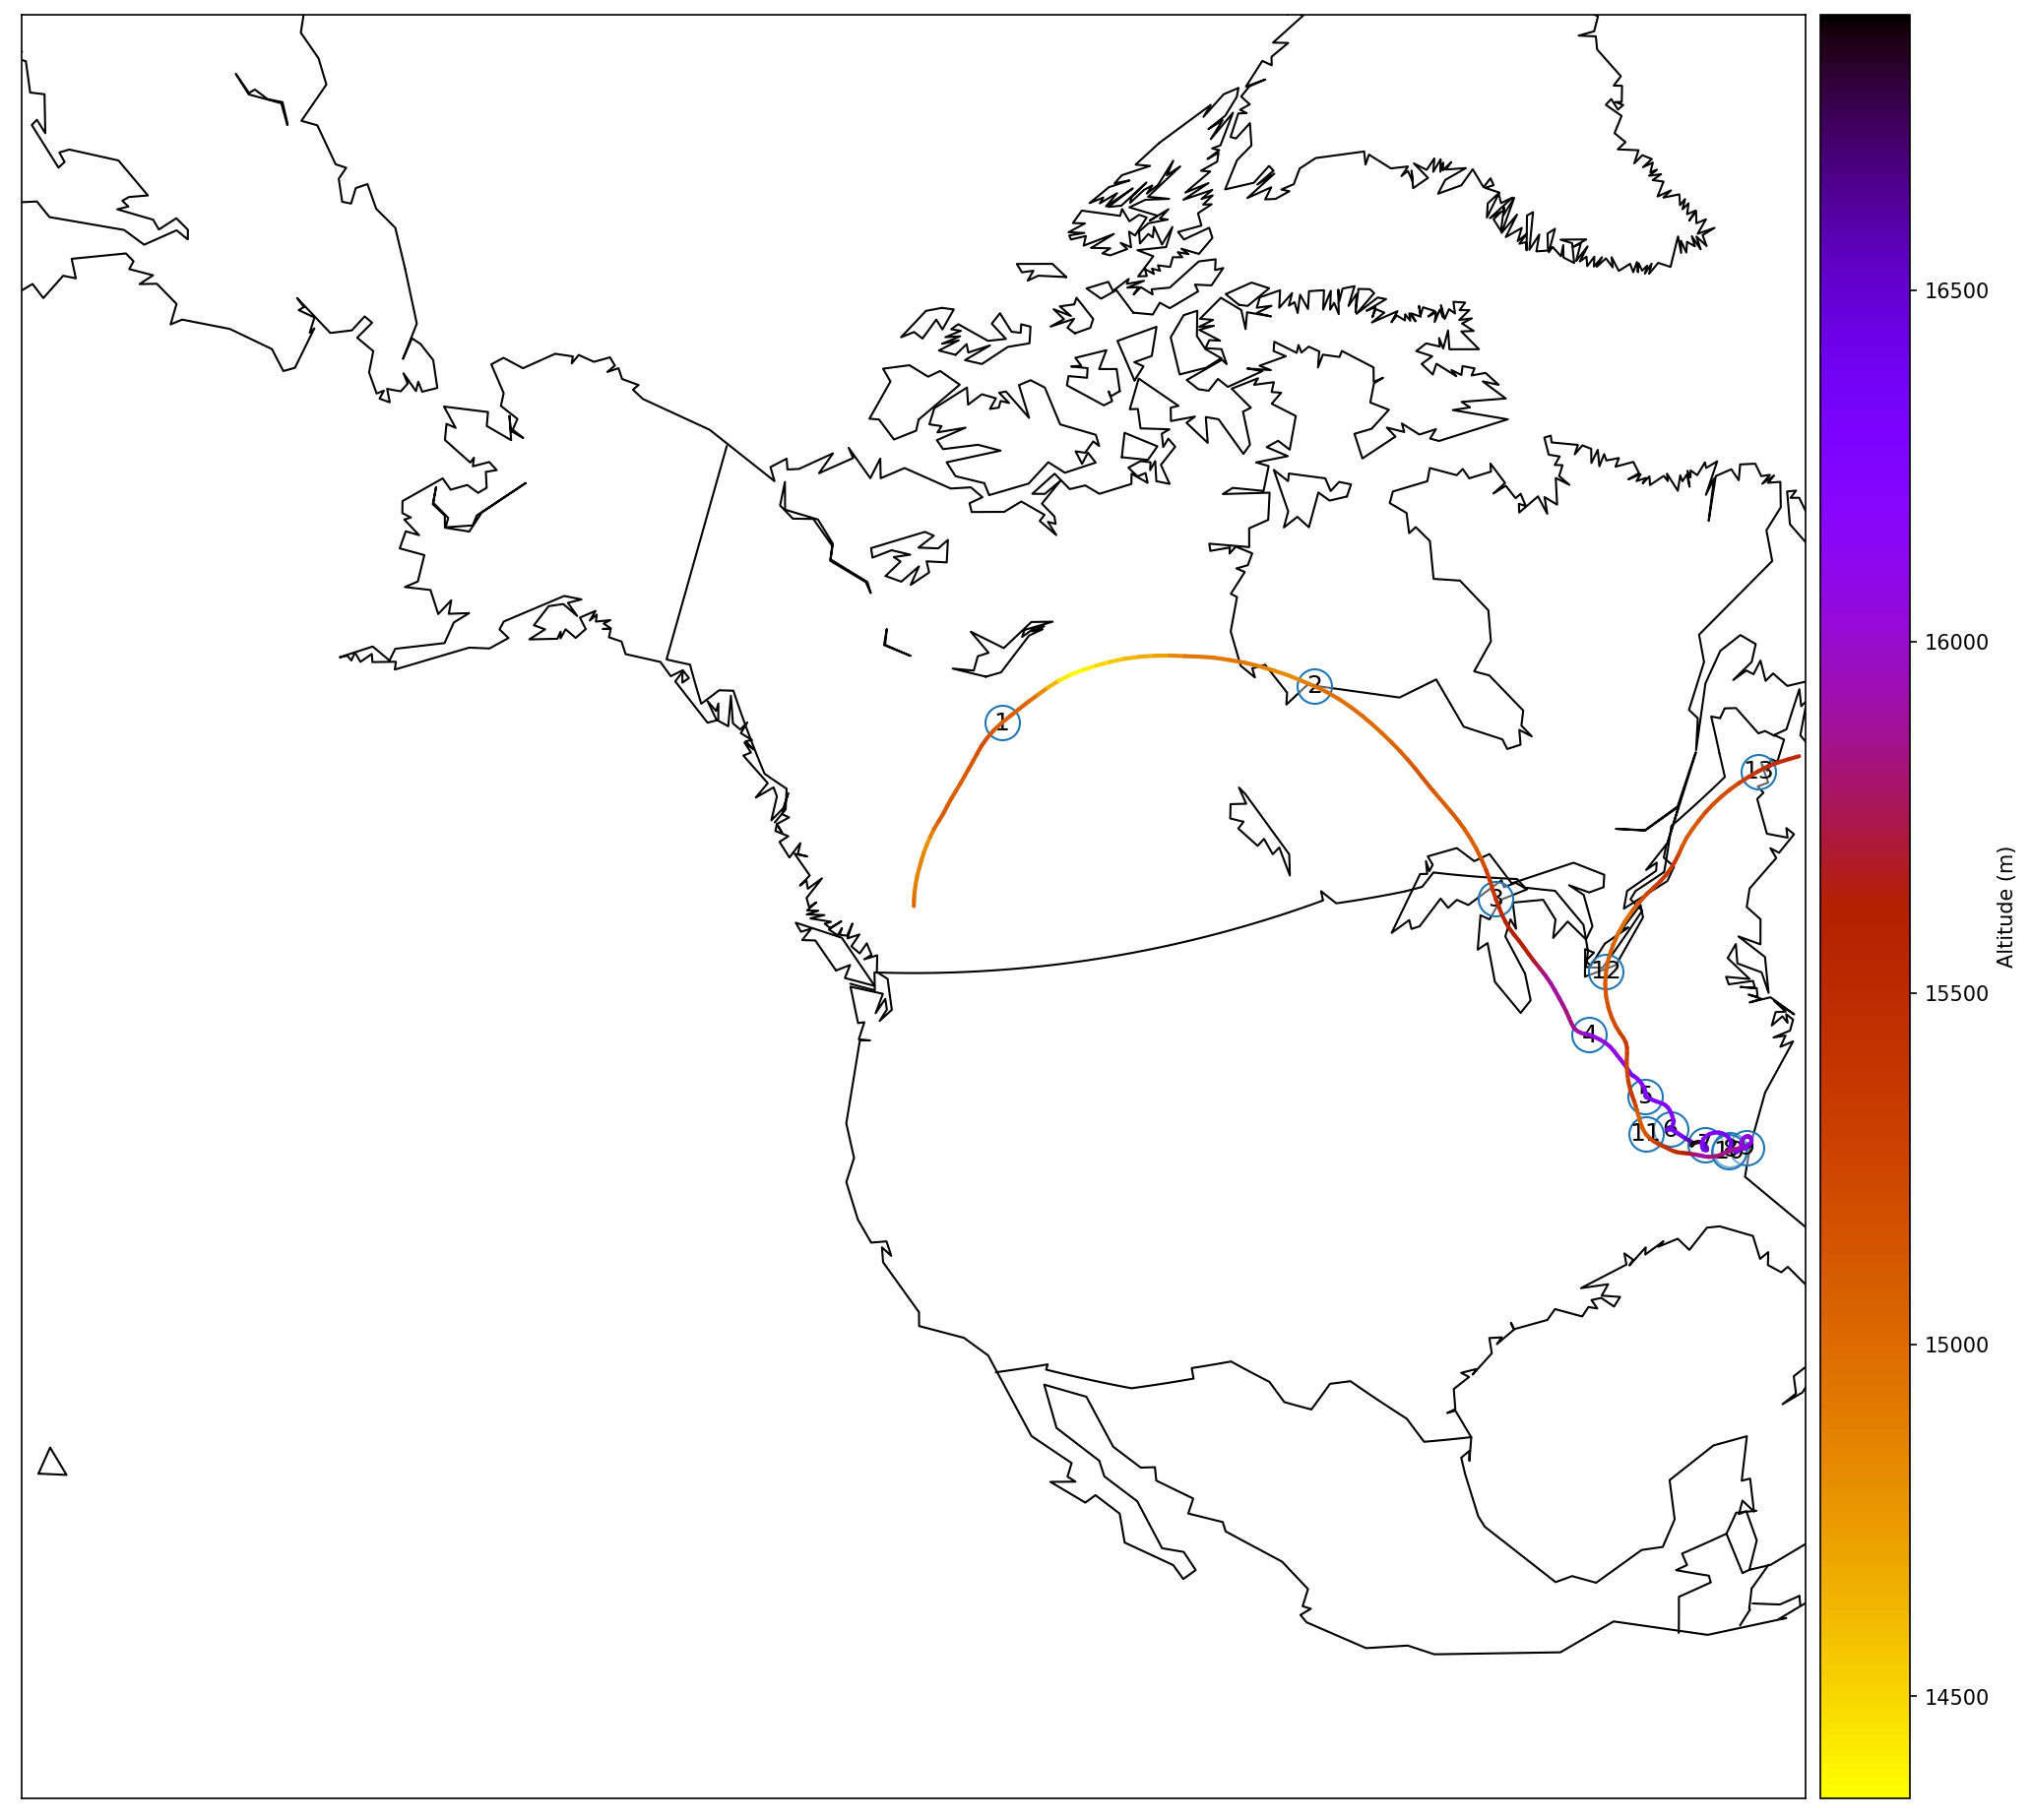

In [59]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 1:
    width = 0.2e6 * 40
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='c',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
# a.set_title(fname)

for run in runs:
    outt = run.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon

if 0:
    width = 0.2e6 * 20
    height = width
    bmap = Basemap(width=width,height=height,
                resolution='h',projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif 1:
    bmap = Basemap(projection='robin',lon_0=0,resolution='c')
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
a.set_title(fname)

outt = run_t.result.plot(bmap = bmap,
#                          lat_c= center[0], lon_c=center[1],
#                          w = 1e4, h = 1e4,
                            color_gradiant=plt.cm.gnuplot_r, scaley = False)
_,_,lc,cb = outt
lc.set_alpha(1)
cb.set_label('Altitude (m)')
lc.set_linewidth(2)
lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)


### concentration

In [ ]:
run_time = 3

In [ ]:
run_c = hysplit_py.Run('concentration', path2hysplit = path2hysplit)
run_c.parameters.input_met_data_folder = path2metfiles
run_c.parameters.predefined_scenes.sgp_aerosol_accu_backwards_gdas1()
run_c.parameters.meterologic_data_format = meterologic_data_format
run_c.parameters.starting_loc = [[coordinates_lat_lon[0], coordinates_lat_lon[1], altitude[0]]]
run_c.parameters.concentration_grids.default.center = [coordinates_lat_lon[0], coordinates_lat_lon[1]]
run_c.parameters.concentration_grids.default.span = [60.0, 360]
run_c.parameters.number_of_samples = 100
run_c.parameters.run_time =  run_time
run_c.parameters.start_time = start_time
# run_c.parameters
run_c.parameters.concentration_grids.default.spacing = [0.01, 0.01]
run_c.parameters.top_of_model_domain = top_of_model_domain


In [ ]:
run_c.parameters.concentration_grids.default.vertical_concentration_levels_height_of_each = 30000

In [ ]:
# run_c.parameters


In [ ]:
# run_t.parameters.start_time = start_time
# run_t.download_missing_meterologic_files()
# pd.options.mode.chained_assignment = 'raise'
# run_t.run()

In [ ]:
run_c.run()

In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 0:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 1:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 1:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 0:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

In [ ]:
# run_c.parameters.start_time = start_time
run_c.download_missing_meterologic_files()

In [ ]:
run_c.result.concentration

In [ ]:
run_c.run()

In [ ]:
run_c.result.concentration

## multi

In [60]:
reload(hysplit_py.split_lab)
reload(hysplit_py)

<module 'hysplit_py' from '/mnt/telg/prog/hysplit-py/hysplit_py/__init__.py'>

In [313]:
run_info

start_datetime  altitude met_format  run_time     lat       lon  \
0 2021-06-30 22:00:00   13000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   14500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   14000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   13500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   17000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   17000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   13000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   13500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   17000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   13000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   13500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   13000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   13500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   17000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   13500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   13000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   17000.0      gdas1       504  51.695 -120.8856   

  hy_mode                         file_name  
0    traj  20210630_220000_13000.0m_traj.nc  
0    traj  20210630_220000_15500.0m_traj.nc  
0    traj  20210630_220000_14500.0m_traj.nc  
0    traj  20210630_220000_16000.0m_traj.nc  
0    traj  20210630_220000_15000.0m_traj.nc  
0    traj  20210630_220000_16500.0m_traj.nc  
0    traj  20210630_220000_14000.0m_traj.nc  
0    traj  20210630_220000_13500.0m_traj.nc  
0    traj  20210630_220000_17000.0m_traj.nc  
1    traj  20210630_223000_16500.0m_traj.nc  
1    traj  20210630_223000_14000.0m_traj.nc  
1    traj  20210630_223000_16000.0m_traj.nc  
1   

In [314]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:651
# start at the end
test = False
# startdt = run_info.copy()
# startdt = startdt[startdt.hy_mode == 'traj'].copy()


out = hysplit_py.split_lab.multirun(run_info,folders, process_number,
                                    test=test, 
                                    skip_error = False,
                                    non_standard_parameters = {'top_of_model_domain':top_of_model_domain},
               # verbose = True
              )
# out = multirun([run_c], startdt,save_base_folder, test=True)

20210630_220000_13000.0m_traj.nc...30000.0
done	20210630_220000_15500.0m_traj.nc...filename exists -> skip
20210630_220000_14500.0m_traj.nc...filename exists -> skip
20210630_220000_16000.0m_traj.nc...filename exists -> skip
20210630_220000_15000.0m_traj.nc...filename exists -> skip
20210630_220000_16500.0m_traj.nc...filename exists -> skip
20210630_220000_14000.0m_traj.nc...filename exists -> skip
20210630_220000_13500.0m_traj.nc...30000.0
done	20210630_220000_17000.0m_traj.nc...filename exists -> skip
20210630_223000_16500.0m_traj.nc...filename exists -> skip
20210630_223000_14000.0m_traj.nc...filename exists -> skip
20210630_223000_16000.0m_traj.nc...filename exists -> skip
20210630_223000_17000.0m_traj.nc...filename exists -> skip
20210630_223000_14500.0m_traj.nc...filename exists -> skip
20210630_223000_15500.0m_traj.nc...filename exists -> skip
20210630_223000_13000.0m_traj.nc...30000.0
done	20210630_223000_13500.0m_traj.nc...30000.0
done	20210630_223000_15000.0m_traj.nc...filena

In [ ]:
# list(save_base_folder.glob('*'))

In [ ]:
res = out[0]

In [ ]:
bla = 0.6e7
lat,lon = coordinates_lat_lon
bmap = Basemap(width=1.5 *bla,height=bla,
            resolution='c',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)
res.plot(bmap = bmap)

In [ ]:
bla = 0.6e7
lat,lon = coordinates_lat_lon
bmap = Basemap(width=1.5 *bla,height=bla,
            resolution='c',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)
res.plot(bmap = bmap)

In [ ]:
print(res.run_settings)

# Dataworkup

## movie

In [ ]:
reload(hysplit_py.split_lab)

In [ ]:
save_base_folder

In [ ]:
res_dict = hysplit_py.open_result_netCDF(save_base_folder, raise_error=False)
# res_dict = hysplit_py.open_result_netCDF('/mnt/telg/tmp/edna/', raise_error=False)

In [ ]:
conc_kwargs =   dict(resolution='l', 
                     back_ground = 'bluemarble',
                     costlines=False, 
                     countries=False, 
                     states=False,
                     lat_c=coordinates_lat_lon[0], 
                     lon_c=coordinates_lat_lon[1] , 
                     w=7890244, 
                     h=6848458, 
                     zoom_out=2, 
                     colorbar=True,
                     plt_kwargs = {'vmin': 1e-19})

In [ ]:
res = res_dict[list(res_dict)[0]]
res.plot(**conc_kwargs)

In [ ]:
lumi = lume.read_file('/mnt/data/data/land_use_data/LCType_0p025.nc')
res_dict.land_use_map = lumi

# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:968
res_dict.source_attribution_landuse#.to_csv('/mnt/data/data/hysplit_products/ENA_IOP_201801_02/ENA_IOP_201801_02.01_overview/source_attribution_landuse.csv')
res_dict.source_attribution_angular#.to_csv('/mnt/data/data/hysplit_products/ENA_IOP_201801_02/ENA_IOP_201801_02.01_overview/source_attribution_angular.csv')

In [ ]:
outputfolder = '/mnt/data/data/hysplit_products/for_joe_2019/20190808_overwiew/'
fname = outputfolder + 'overveiw.mp4'
res_dict.create_movie_overview(fname, dpi = 200, 
                               test = False, 
                               conc_kwargs=conc_kwargs, 
                               save_figures2folder = outputfolder + 'figures/',
                               create_from_saved_figs = True,)

## from run_info

### all on one map (open files before plotting)

In [ ]:
reload(hysplit_py)
reload(hysplit_py.split_lab)

In [315]:
run_info

start_datetime  altitude met_format  run_time     lat       lon  \
0 2021-06-30 22:00:00   13000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   14500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   15000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   16500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   14000.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   13500.0      gdas1       504  51.695 -120.8856   
0 2021-06-30 22:00:00   17000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   16000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   17000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   14500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   13000.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   13500.0      gdas1       504  51.695 -120.8856   
1 2021-06-30 22:30:00   15000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   16000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   17000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   15000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   13000.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   13500.0      gdas1       504  51.695 -120.8856   
2 2021-06-30 23:00:00   14000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   13000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   13500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   17000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   16000.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   15500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14500.0      gdas1       504  51.695 -120.8856   
3 2021-06-30 23:30:00   14000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   13500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   16500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   13000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   14500.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   15000.0      gdas1       504  51.695 -120.8856   
4 2021-07-01 00:00:00   17000.0      gdas1       504  51.695 -120.8856   

  hy_mode                         file_name  
0    traj  20210630_220000_13000.0m_traj.nc  
0    traj  20210630_220000_15500.0m_traj.nc  
0    traj  20210630_220000_14500.0m_traj.nc  
0    traj  20210630_220000_16000.0m_traj.nc  
0    traj  20210630_220000_15000.0m_traj.nc  
0    traj  20210630_220000_16500.0m_traj.nc  
0    traj  20210630_220000_14000.0m_traj.nc  
0    traj  20210630_220000_13500.0m_traj.nc  
0    traj  20210630_220000_17000.0m_traj.nc  
1    traj  20210630_223000_16500.0m_traj.nc  
1    traj  20210630_223000_14000.0m_traj.nc  
1    traj  20210630_223000_16000.0m_traj.nc  
1   

In [381]:
# open files
run_info.index = range(run_info.shape[0]) # this is to make sure the index is unique
run_info['result'] = np.nan
p2fld = save_base_folder
for idx, row in run_info.iterrows():
    p2fl = p2fld.joinpath(row.file_name)
    result = hysplit_py.open_result_netCDF(p2fl)
    run_info.loc[idx,'result'] = result

In [382]:
# get maximum and minimum altitude
alt_max = np.max([res.trajectory['altitude_above_ground(m)'].max() for res in run_info.result.values])
alt_min = np.min([res.trajectory['altitude_above_ground(m)'].min() for res in run_info.result.values])
alt_min,alt_max

(5536.9, 18470.9)

In [407]:
# remove data close to dateline    
lon_datechange = 180
lon_datechange_d = 2
for idx,row in run_info.iterrows():
    ldmod = row.result.trajectory.longitude.mod(lon_datechange)
    lt = row.result.trajectory.longitude.abs()
    # ldmod[ldmod < lon_datechange_d] = np.nan
    # result.trajectory[ldmod < lon_datechange_d] = np.nan
    # row.result.trajectory.loc[ldmod.index[ldmod < lon_datechange_d],['altitude_above_ground(m)', 'age_of_trajectory(h)', 'PRESSURE']] = -9999
    # row.result.trajectory.loc[ldmod.index[ldmod > (lon_datechange - lon_datechange_d)],['altitude_above_ground(m)', 'age_of_trajectory(h)', 'PRESSURE']] = -9999
    row.result.trajectory.loc[lt.index[abs(lt-180) < (lon_datechange_d)],['altitude_above_ground(m)', 'age_of_trajectory(h)', 'PRESSURE']] = -9999
    # print((lt.index[abs(lt-180) < (lon_datechange_d)]).shape)
    row.result.trajectory.loc[lt.index[abs(lt-360) < (lon_datechange_d)],['altitude_above_ground(m)', 'age_of_trajectory(h)', 'PRESSURE']] = -9999

In [408]:
cm = plt.cm.nipy_spectral_r.copy()
cm.set_under([0,0,0,0])

In [409]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['lines.linewidth'] = 1

#### all lines

In [410]:
run_info_sel = run_info.copy()

# run_info_sel = run_info_sel[run_info_sel.start_datetime >= '2021-06-30 23:00:00']
# run_info_sel = run_info_sel[run_info_sel.altitude <= 16000]

run_info_sel.shape

(45, 9)

.............................................

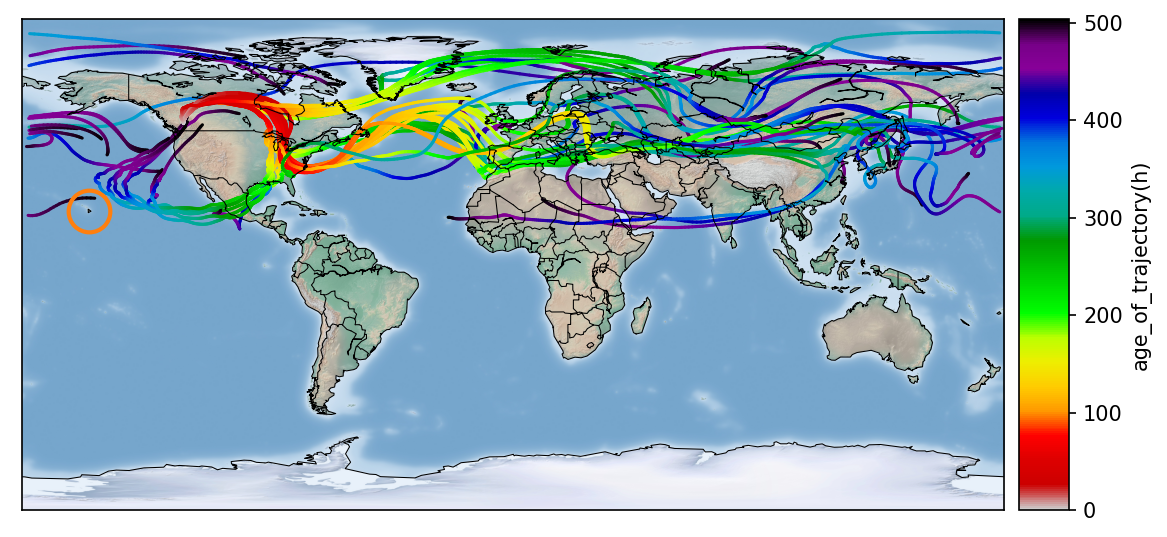

In [411]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
intensity = 'age_of_trajectory(h)'# not really working
# intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 3 * 7 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except:
        print('fail', end = '')
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

In [412]:
399/24

16.625

.............................................

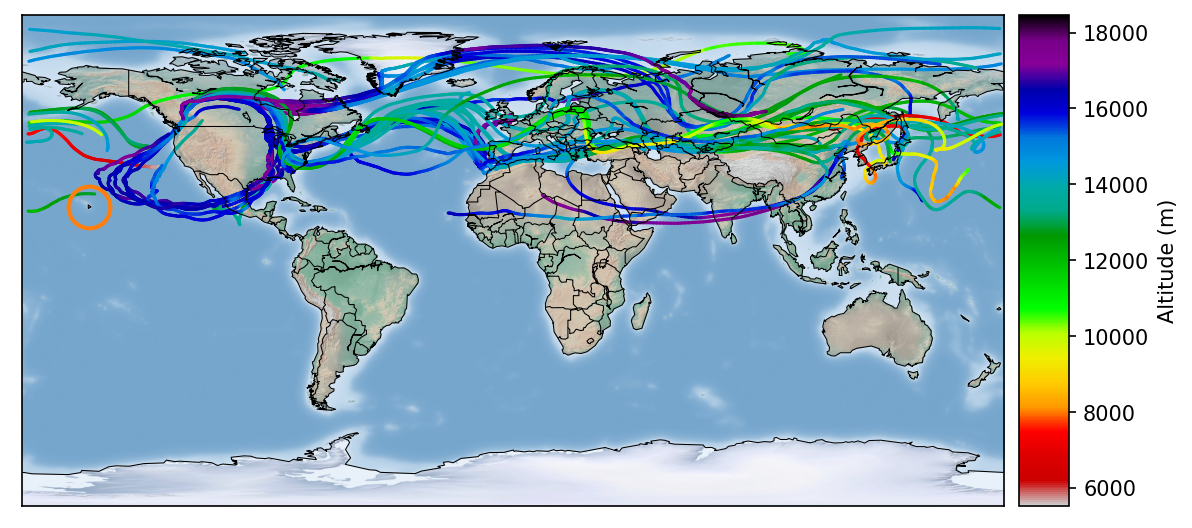

In [413]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
# intensity = 'age_of_trajectory(h)'# not really working
intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 14 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            if e == 0:
                cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except Exception as err:
        print('fail', end = '')
        raise
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

#### selection

In [414]:
run_info_sel = run_info.copy()

# run_info_sel = run_info_sel[run_info_sel.start_datetime >= '2021-06-30 23:00:00']
run_info_sel = run_info_sel[run_info_sel.altitude <= 14000]
# run_info_sel = run_info_sel[run_info_sel.altitude >= 14000]
run_info_sel.shape

(15, 9)

...............

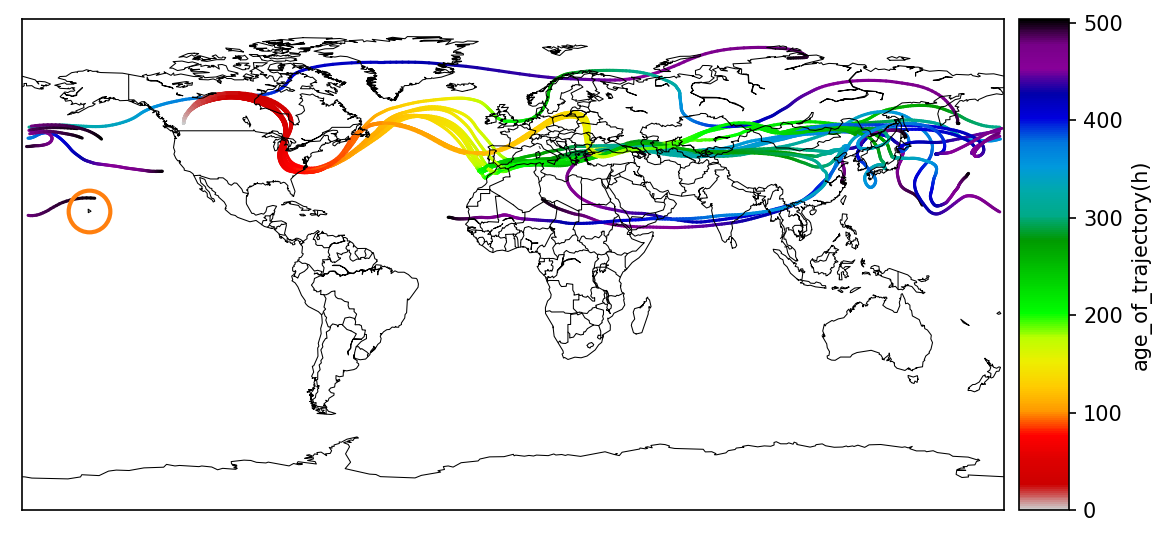

In [415]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
intensity = 'age_of_trajectory(h)'# not really working
# intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
# bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 3 *  7 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except:
        print('fail', end = '')
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

.........................

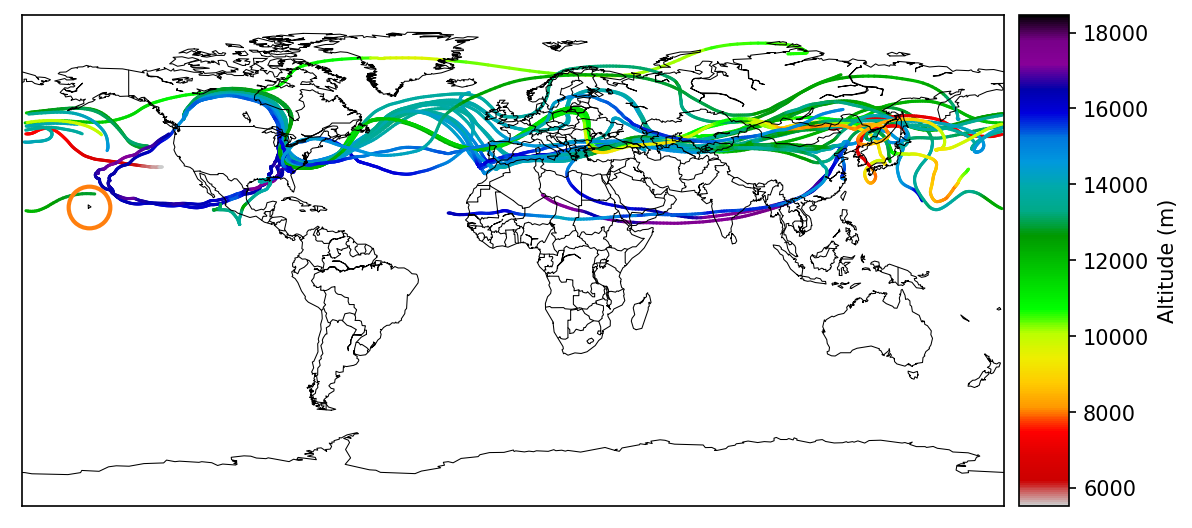

In [395]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
# intensity = 'age_of_trajectory(h)'# not really working
intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
# bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 14 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            if e == 0:
                cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except Exception as err:
        print('fail', end = '')
        raise
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

In [275]:
run_info_sel = run_info.copy()

# run_info_sel = run_info_sel[run_info_sel.start_datetime >= '2021-06-30 23:00:00']
# run_info_sel = run_info_sel[run_info_sel.altitude <= 16000]

run_info_sel.shape

(35, 9)

...................................

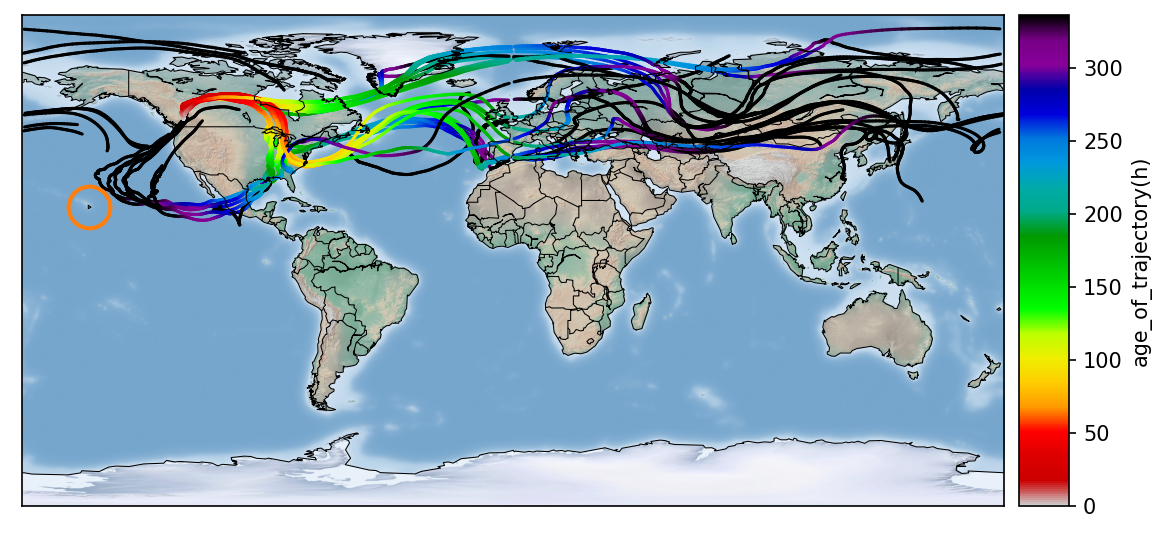

In [277]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
intensity = 'age_of_trajectory(h)'# not really working
# intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 14 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except:
        print('fail', end = '')
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

...................................

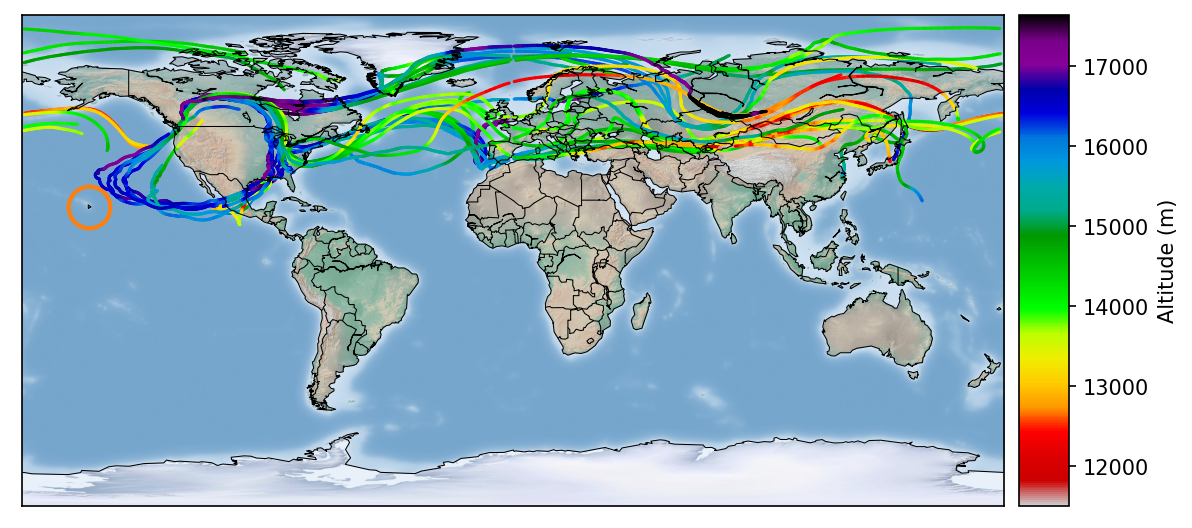

In [278]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = True
# intensity = 'age_of_trajectory(h)'# not really working
intensity = 'altitude_above_ground(m)'

# for local
zoom = 100 # smaller value -> higer zoom
aspect = 0.5 # y/x 
show_center = True
# lat,lon = coordinates_lat_lon
lat,lon = (24.285, 141.481) # Fukutoku-Okanoba
lat,lon = (19.5362, -155.5763) # MLO

lat_center = lat + 30
lon_center = lon - 80

if not world:
    width = 0.2e6 * zoom
    height = width * aspect
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon_center,lat_0=lat_center)
    
elif world:
    proj = 'cyl' # robin
    bmap = Basemap(projection=proj,lon_0=0,resolution=resolution)
    
    
bmap.shadedrelief()
# bmap.bluemarble()
bmap.drawcoastlines(linewidth = 0.5)
# bmap.drawstates()
bmap.drawcountries(linewidth = 0.5)

if show_center:
    g, = bmap.plot(lon, lat, latlon = True, ls = '', marker = 'o')
    g.set_markersize(20)
    g.set_markerfacecolor([1,1,1,0])
    g.set_markeredgecolor(colors[1])
    g.set_markeredgewidth(2)

a = plt.gca()
# a.set_title(fname)

# plot the results
for e,(idx, row) in enumerate(run_info_sel.iterrows()):
    print('.', end = '')
    if e == 0:
        colorbar = True
    else:
        colorbar = False
        
    result = row.result
    try:
        outt = result.plot(bmap = bmap,
                           intensity = intensity,
        #                          lat_c= center[0], lon_c=center[1],
        #                          w = 1e4, h = 1e4,
                           show_days = False,
                           colorbar = colorbar,
                           fontsize = 8,
                           color_gradiant=cm, 
                           scaley = False,
                           # zorder = 100,
                          )
        _,_,lc,cb = outt
        # lc.set_alpha(1)
        if intensity == 'age_of_trajectory(h)':
            lc.set_clim(0, 14 * 24)
            pass
        else:
            lc.set_clim(alt_min, alt_max)
            if e == 0:
                cb.set_label('Altitude (m)')
        # lc.set_zorder(100)
    except Exception as err:
        print('fail', end = '')
        raise
        continue
f = plt.gcf()
scalef = 1.5
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

In [ ]:
g.set_markeredgewidth(2)


### all on one map (open files on the go)

In [ ]:
run_info

In [ ]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
resolution = 'c'
world = False

lat,lon = coordinates_lat_lon

if not world:
    width = 0.2e6 * 40
    height = width
    bmap = Basemap(width=width,height=height,
                resolution=resolution,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat)
    
elif world:
    bmap = Basemap(projection='robin',lon_0=0,resolution=resolution)
bmap.drawcoastlines(linewidth = 1)
# bmap.drawstates()
bmap.drawcountries(linewidth = 1)

a = plt.gca()
# a.set_title(fname)

for idx, row in run_info.iterrows():
    p2fl = p2fld.joinpath(row.file_name)
    result = hysplit_py.open_result_netCDF(p2fl)
    outt = result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)
f = plt.gcf()
scalef = 4
f.set_figheight(f.get_figheight() * scalef)
f.set_figwidth(f.get_figwidth() * scalef)

In [ ]:
reload(hysplit_py)
reload(hysplit_py.split_lab)

## with source attribution

In [ ]:
def get_bmap(a, 
             res = 'c', #'i'
#              scale = 1.2
            ):
    lat,lon = coordinates_lat_lon
    wh = 5e6
#     f,a = plt.subplots(3)
    bmap = Basemap(ax = a,width=2 * wh,height=wh,
                resolution=res,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat,
                  )
#     print(bmap)
    bmap.drawcoastlines(linewidth = 0.4)
    bmap.drawstates(linewidth = 0.2)
    bmap.drawcountries(linewidth = 0.4)
    bmap.bluemarble()
    
    return bmap

In [ ]:
def plot_traj(traj,bmap, dt, alt, a):
    _,a,lc,cb = traj.plot(bmap= bmap, zorder = 60, color_gradiant=plt.cm.gnuplot_r)
    cb.set_label('Altitude above ground (m)')
    lc.set_clim(0,5e3)
    title = a.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
    
    return bmap, a, lc, cb

def plot_conc(conc, bmap, dt, alt,a):
#     a = plt.subplot()
#     bmap = get_bmap(a,low_res = True)
    f,a,_,pc,cb = conc.plot(bmap=bmap, plt_kwargs={})
    pc.set_clim(1e-19,1e-15)
    cm = copy.copy(plt.cm.get_cmap("gnuplot_r"))
    cm.set_under(color = [1,1,1,0])
    pc.set_cmap(cm)
    title = a.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
    return bmap, a, pc,cb
    

In [ ]:
path2figs = '/mnt/data/data/hysplit_products/4Evguieni_ENA_dust/coarse_mode/201712/figures/'
path2figs = pathlib.Path(path2figs)
path2figs.mkdir(exist_ok=True)
# path2data = pathlib.Path('/mnt/data/data/hysplit_products/ENA_dust/201712/data/')

In [ ]:
lumi = lume.read_file('/mnt/data/data/land_use_data/LCType_0p025.nc')


In [ ]:
def plot_from_runinfo(what = 'conc', save = False, low_res = True, lumi = False, save_base_folder = save_base_folder,
                      path2figs = None, test = False, use_conc = None):

    ####################
    # traj = False
    # conc = True
    # assert(not (traj and conc)), 'only traj or conc'

    path2folder_res = pathlib.Path(save_base_folder)
    if what == 'source':
        f = plt.figure()
        f.set_figwidth(f.get_figwidth() * 1.7)
        no_rows = len(altitude)
        f.set_figheight(f.get_figheight() * no_rows)
        aa = []
        for i in range(no_rows):
            a_angle = f.add_subplot(no_rows,2,(i*2)+1,projection = 'polar')
            a_lu = f.add_subplot(no_rows,2,(i*2)+2, )
            aa.append([a_angle, a_lu])
    else:
        f, aa = plt.subplots(len(altitude), gridspec_kw={'hspace': 0.1})
        scale = 3
        f.set_figheight(f.get_figheight() * scale)
        f.set_figwidth(f.get_figwidth() * scale)
        
    for i,dt in enumerate(run_info.start_datetime.unique()):
        print(dt)
        st_df = run_info.loc[run_info.start_datetime == dt]

    #     f.clear()
        if what == 'source':
            for a in aa:
                for at in a:
                    at.clear()
        else:
            for a in aa:
                a.clear()

        for e,alt in enumerate(altitude):

            a = aa[e]
#             print(aa)
            if what != 'source':
                bmap = get_bmap(a, low_res = low_res)
            sa_df = st_df.loc[st_df.altitude == alt]

            if what == 'traj':
    #             assert(False)
                path2traj = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'traj'].file_name.iloc[0])

                # open file
                # 
                traj = hysplit_py.open_result_netCDF(path2traj)

                bmap, a, lc, cb = plot_traj(traj, bmap, dt, alt, a)
                # save figure
            #     p2f = path2figs.joinpath(path2traj.name.replace('.nc', '.png'))
            #     f.patch.set_alpha(0)
            #     f.savefig(p2f, dpi = 200, bbox_inches = 'tight')

            elif what == 'conc':
                path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                conc = hysplit_py.open_result_netCDF(path2conc)
                try:
                    bmap, a, pc, cb = plot_conc(conc, bmap, dt, alt, a)
                except:
                    print('problem plotting concentration ... skip.')
                    continue
    #             assert(False)
            elif what == 'source':
                if isinstance(use_conc, type(None)):
                    path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                    conc = hysplit_py.open_result_netCDF(path2conc)
                    conc.source_attribution_land_use.land_use_map = lumi
                else:
                    conc = use_conc
                a_ang, a_lu = a
                conc.source_attribution_angular.plot(ax = a_ang)
                conc.source_attribution_land_use.plot(ax = a_lu, style='bar')
                # f.subplots_adjust(wspace  = 1)
                f.tight_layout()
                title = a_ang.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
#                 assert(False), 'test'
            else:
                assert(False), 'geht nich'

        if save:
            dt = pd.to_datetime(dt)
            name = f'{dt.year:04d}{dt.month:02d}{dt.day:02d}_{dt.hour:02d}{dt.minute:02d}{dt.second:02d}_{what}.png'
            p2ff = path2figs.joinpath(what)
            p2ff.mkdir(exist_ok=True)
            p2f = p2ff.joinpath(name)
            f.patch.set_alpha(0)
            try:
                f.savefig(p2f, dpi = 200, bbox_inches = 'tight')
            except:
                print("problem with printing the figure ... skip")
                continue
        if test:
            assert(False)
#             if i == 2:
#                 break

    
            

In [ ]:
plot_from_runinfo(
    what='source',
#     save_base_folder=path2data,
    save=False,
#     low_res=False,
    test=True,
#     conc = conc,
    lumi = None)

In [ ]:
plot_from_runinfo(
    what='traj',
#     save_base_folder=path2data,
    save=True,
    low_res=False,
    test=False,)

In [ ]:
plot_from_runinfo(
    what='conc',
#     save_base_folder=path2data,
    save=True,
    low_res=False,
    test=False,)

### old

In [ ]:
path2folder_res = pathlib.Path(save_base_folder)

In [ ]:
alt = altitude[0]
file_list_traj = list(path2folder_res.glob(f'*{alt}m_traj*'))
file_list_conc = list(path2folder_res.glob(f'*{alt}m_conc*'))
file_list_traj.sort()
file_list_conc.sort()

In [ ]:
list(zip(file_list_traj, file_list_conc))[0]

In [ ]:
pathfold = '/mnt/data/data/hysplit_products/ENA_dust/201903/'
pathfold = pathlib.Path(pathfold)
fnamelist = list(pathfold.glob('*'))
fnamelist = list(np.unique(['_'.join(fn.name.split('_')[:2]) for fn in fnamelist]))

In [ ]:
i= 1
fname = pathfold.joinpath(fnamelist[i])
fn_conc = fname.as_posix()+'_conc.nc'
fn_traj = fname.as_posix()+'_traj.nc'
fn_conc

In [ ]:
conc = hysplit_py.open_result_netCDF(fn_conc)
traj = hysplit_py.open_result_netCDF(fn_traj)

In [ ]:
w = 3e6

outt = traj.plot(color_gradiant=plt.cm.cool,
                     resolution='c', 
                     back_ground = 'bluemarble',
                     zorder = 100, 
                     w = w, h=w)
bmap,_,_ = outt
out = conc.plot(bmap = bmap, 
                colorbar=False
               )
#                 lat_c=coordinates_lat_lon[0], 
#                 lon_c=coordinates_lat_lon[1],
#                 w = w, h= w)

lc = outt[2]

lc.set_alpha(1)

## from list

In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
plt.rcParams['figure.dpi'] = 100

In [ ]:
reload(hysplit_py)
reload(hysplit_py.split_lab)
reload(hysplit_py.split_lab._plt_tools.colorbar)

In [ ]:
pathfold = pathlib.Path('/mnt/data/data/hysplit_products/for_joe_2019/march/20200121/data/')#20141202_194437_conc.nc')
pathfoldout = pathlib.Path('/mnt/data/data/hysplit_products/for_joe_2019/march/20200121/figure_traj/')

In [ ]:
test = False
w = 3e6
concentation = False
if test:
    res = 'c'
    xpixels = 100
    dpi = 50
else:
    res = 'i'
    xpixels = 1000
    dpi = 100

In [ ]:
df

In [ ]:
import warnings

In [ ]:
overwrite = False
lat,lon = coordinates_lat_lon

for idx in df.index.unique():
    if 0:
        if idx != 13:
            continue
              
    sel = df.loc[idx,:].sort_values('start_times')


    f,aa = plt.subplots(1,3)
    f.set_size_inches(f.get_size_inches()*3)
    i = -1
    fnameout = None
    for ix, row in sel.iterrows():
        i+=1
    #     pass
    #     i= 1
        a = aa[i]

        fname = pathfold.joinpath(str(row.start_times).replace('-','').replace(':', '').replace(' ','_'))
        fn_conc = fname.as_posix()+'_conc.nc'
        fn_traj = fname.as_posix()+'_traj.nc'
        print(fname)


#         if concentation:
            
        if not pathlib.Path(fn_traj).is_file():
            if i == 1:
                warnings.warn('The center file ({}) was missing ... no figure created'.format(pathlib.Path(fn_traj).name))
                break
            else:
                warnings.warn('File {} missing ... there will be plot missing'.format(pathlib.Path(fn_traj).name))
                continue
                
        traj = hysplit_py.open_result_netCDF(fn_traj)

        # bgfname = '/'
        bmap = Basemap(resolution = res,
                       width=w, height=w*2,
                      llcrnrlon=lon-28,llcrnrlat=lat-12,urcrnrlat=79,urcrnrlon=-35,
        #               lat_0=71.2906, lon_0=156.7886,
                      epsg = 3572,
                      ax = a)
        #     llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, epsg=5520)
        #http://server.arcgisonline.com/arcgis/rest/services


        outt = traj.plot(bmap = bmap,
                        color_gradiant=plt.cm.gnuplot_r,
                             resolution=res, 
        #                      back_ground = 'bluemarble',
                             zorder = 100, 
                             w = w, h=w,
                          colorbar = {'position': 'bottom',
                                     'pad':0.2},
                          verbose = False)
        bmap,_,lc,cb = outt
        lc.set_alpha(1)
        cb.set_label('Altitude (m)')
        lc.set_linewidth(2)
        
        if concentation:
            conc = hysplit_py.open_result_netCDF(fn_conc)
            out = conc.plot(bmap = bmap, 
                            colorbar=False
                           )
            a = out[1]
        
        parallels = np.arange(0.,81,5.)
        latmax = 85
        bmap.drawparallels(parallels,labels=[False,True,True,False], latmax=latmax)
        
        meridians = np.arange(10.,351.,20.)
        bmap.drawmeridians(meridians,labels=[True,False,False,True], latmax=latmax)

        if  1:
            bmap.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = xpixels, verbose= True)
            bmap.drawcoastlines(linewidth=0.5)
            
        dt = row.start_times
        tposx = 0.05
        tposy = 0.92
        if i == 1:
            fnameout = '{:04d}{:02d}{:02d}_{:02d}{:02d}{:02d}.png'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
            a.text(tposx, tposy, dt, size = 14, zorder = 200, transform = a.transAxes,
                  bbox=dict(boxstyle="round",
#                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
#                             alpha = 0.5
                           )
                  )
        if i==0:
            tt = '- 1 day'
            a.text(tposx, tposy, tt, size = 14, zorder = 200, transform = a.transAxes,
                    bbox=dict(boxstyle="round",
        #                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
        #                             alpha = 0.5
                           )
                  )
        elif i==2:
            tt = '+ 1 day'
            a.text(tposx, tposy, tt, size = 14, zorder = 200, transform = a.transAxes,
                    bbox=dict(boxstyle="round",
        #                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
        #                             alpha = 0.5
                           )
                  )
            
        
    # in case the center file is missing ... continue
    if isinstance(fnameout, type(None)):
        continue
#         continue
    pathout = pathfoldout.joinpath(fnameout)
    if not overwrite:
        if pathout.is_file():
            print('file {} exists ... skip'.format(pathout.name))
    
    f.patch.set_alpha(0)
#     a.set_axis_off()
#     f.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     a.margins(0,0)
    f.savefig(pathout, dpi = dpi, bbox_inches = 'tight',
#               pad_inches = 0,
             )
    if test:
        assert(False)


In [ ]:
import plt_tools

In [ ]:
plt_tools.colorbar.colorbar_axis_split_off()

In [ ]:
f.colorbar()

# Meterological formats

https://www.ready.noaa.gov/archives.php look for the readme files

## gdas1

In [ ]:
fname = '/mnt/data/data/hysplit_met_files/gdas1/gdas1.apr21.w2'

In [ ]:
# ds = xr.open_dataset(fname, engine='cfgrib')

### altitudes, roughly

In [ ]:
import atmPy.atmosphere.standards as atmstd

In [ ]:
alt,t = atmstd.standard_atmosphere(pd.Series(np.array([20,50,100])),
                           quantity='pressure'
                          )

In [ ]:
alt/1e3

## gfs 0.25

### altitudes, roughly

In [ ]:
import atmPy.atmosphere.standards as atmstd

In [ ]:
ab2p = lambda ab: int(str(ab).split('.')[0]) + int(str(ab).split('.')[1])
ab2p(16.853)

In [ ]:
apb = [0.9999, 0.9947, 0.9886, 0.9817, 0.9739,
1.9648, 1.9544, 2.9425, 4.9288, 6.9132,
8.8954, 11.875, 16.853, 21.827, 26.799,
33.769, 41.735, 49.699, 59.660, 69.619,
80.576, 91.531, 102.49, 113.44, 123.39,
133.35, 143.30, 151.26, 157.22, 162.18,
165.15, 166.12, 165.09, 162.07, 157.05,
150.04, 142.02, 132.01, 122.01, 111.00,
99.002, 88.000, 78.000, 68.000, 59.000, 
52.000, 45.000, 39.000, 34.000, 29.000,
25.000, 21.000, 18.000, 15.000, 13.000]

In [ ]:
p = np.array([ab2p(i) for i in apb])

In [ ]:
ps = p[11:]
ps

In [ ]:
alt,t = atmstd.standard_atmosphere(pd.Series(ps),
                           quantity='pressure'
                          )

In [ ]:
alt = alt/1e3

In [ ]:
np.array([round(a) for a in alt])



# era interim files

In [ ]:
from ecmwfapi import ECMWFDataServer    

In [ ]:
server = ECMWFDataServer()

In [ ]:
server.retrieve({
    'stream'    : "oper",
    'levtype'   : "sfc",
    'param'     : "165.128/166.128",
    'dataset'   : "interim",
    'step'      : "0",
    'grid'      : "0.75/0.75",
    'time'      : "18",
    'date'      : "2012-07-20/2012-07-21/2013-02-23/2013-02-24",
    'type'      : "an",
    'class'     : "ei",
    'format'    : "netcdf",
    'target'    : "TCAP2goldendays_v10u10_ext.nc"
 })

In [ ]:
from erainterim import era_lab as el

In [ ]:
reload(el)

In [ ]:
fname = fname = '/Volumes/HTelg_4TB_Backup/era_interim_files/TCAP2goldendays_v10u10_ext.nc'
erant4 = el.load_nc(fname)

In [ ]:
fname = fname = '/Volumes/HTelg_4TB_Backup/era_interim_files/TCAP2goldendays_v10u10.nc'
erant2 = el.load_nc(fname)

In [ ]:
f,a,sl,cb = erant4.wind_10.plot_streamlines(3, vmin = 0, vmax = 18)

In [ ]:
f,a = plt.subplots(2,3)
# f.set_size_inches(f.get_size_inches() * 2)
f.set_figwidth(20)
f.set_figheight(11)
((as1,as2,as3),(aw1,aw2,aw3)) = a

vmin = 0
vmax = 18
erant4.wind_10.plot_streamlines(0,ax = as1, vmin = vmin, vmax = vmax)
erant4.wind_10.plot_streamlines(1,ax = as2, vmin = vmin, vmax = vmax)
erant2.wind_10.plot_streamlines(0,ax = as3, vmin = vmin, vmax = vmax)

erant4.wind_10.plot_streamlines(2,ax = aw1, vmin = vmin, vmax = vmax)
erant4.wind_10.plot_streamlines(3,ax = aw2, vmin = vmin, vmax = vmax)
erant2.wind_10.plot_streamlines(1,ax = aw3, vmin = vmin, vmax = vmax)
